In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# File: EfficientNetB0_Model.ipynb
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import os



In [49]:
# --- 1. Parameters & Data Loading ---

print("--- Downloading and Extracting Dataset ---")

zip_path = tf.keras.utils.get_file(
    origin='https://zenodo.org/records/16749554/files/PY-CrackDB.zip?download=1',
    fname='PY-CrackDB.zip',
    extract=True,
    archive_format='zip'
)

--- Downloading and Extracting Dataset ---


In [50]:

# The file extracts to a folder named 'PY-CrackDB_extracted'
base_dir = os.path.dirname(zip_path)
extracted_dir_name = 'PY-CrackDB_extracted'
data_dir = os.path.join(base_dir, extracted_dir_name, 'Classification')

print(f"Data successfully downloaded and extracted.")
print(f"Using data from: {data_dir}")

Data successfully downloaded and extracted.
Using data from: /root/.keras/datasets/PY-CrackDB_extracted/Classification


In [51]:
# --- 1b. Set Model & Training Parameters ---

IMG_WIDTH, IMG_HEIGHT = 224, 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32
NUM_CLASSES = 2
VALIDATION_SPLIT = 0.2

EPOCHS_HEAD = 8
EPOCHS_FINE_TUNE = 10
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FINE_TUNE = 1e-5

In [52]:
# Data augmentation

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)


In [53]:
# Flow data from directories

print("\nLoading Training Data:")
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

print("\nLoading Validation Data:")
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

print(f"\nClass indices: {train_generator.class_indices}")
class_labels = list(train_generator.class_indices.keys())


Loading Training Data:
Found 456 images belonging to 2 classes.

Loading Validation Data:
Found 113 images belonging to 2 classes.

Class indices: {'With crack': 0, 'Without crack': 1}


In [54]:
# --- 2. Model Building (Transfer Learning) ---

#
# Load base model
base_model = EfficientNetB0(weights='imagenet', include_top=False,
                            input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

base_model.trainable = False


inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)


In [55]:
# --- 3. Initial Training (Head Only) ---

print("\n--- Training classification head ---")
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE_HEAD),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

start_time_train_head = time.time()
history_head = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_HEAD
)
end_time_train_head = time.time()
print(f"Head training time: {end_time_train_head - start_time_train_head:.2f} seconds")



--- Training classification head ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
14/14 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.8381 - loss: 0.3583 - val_accuracy: 0.9896 - val_loss: 0.0643
Epoch 2/8
 1/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9688 - loss: 0.0842

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 641ms/step - accuracy: 0.9688 - loss: 0.0842 - val_accuracy: 0.9792 - val_loss: 0.0333
Epoch 3/8
14/14 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.9619 - loss: 0.0903 - val_accuracy: 1.0000 - val_loss: 0.0094
Epoch 4/8
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 1.0000 - loss: 0.0184 - val_accuracy: 0.9896 - val_loss: 0.0256
Epoch 5/8
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9819 - loss: 0.0431 - val_accuracy: 0.9896 - val_loss: 0.0182
Epoch 6/8
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 631ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.9896 - val_loss: 0.0222
Epoch 7/8
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9926 - loss: 0.0260 - val_accuracy: 0.9896 - val_loss: 0.0640
Epoch 8/8
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 543ms/step - accuracy: 0.9688 - loss: 0.0931 - val_accuracy: 0.9792 - val_loss: 0.0240
Head training time: 267.25 seconds


In [56]:
# --- 4. Fine-Tuning (Unfreeze layers) ---
print("\n--- Fine-tuning model ---")

base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block7a_expand_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


model.compile(optimizer=Adam(learning_rate=LEARNING_RATE_FINE_TUNE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

start_time_fine_tune = time.time()
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_FINE_TUNE,
    initial_epoch=history_head.epoch[-1]
)
end_time_fine_tune = time.time()
total_training_time = (end_time_train_head - start_time_train_head) + (end_time_fine_tune - start_time_fine_tune)
print(f"Fine-tuning time: {end_time_fine_tune - start_time_fine_tune:.2f} seconds")
print(f"Total training time: {total_training_time:.2f} seconds")




--- Fine-tuning model ---
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.9573 - loss: 0.1421 - val_accuracy: 0.9896 - val_loss: 0.0270
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9688 - loss: 0.1144 - val_accuracy: 1.0000 - val_loss: 0.0118
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9471 - loss: 0.1272 - val_accuracy: 0.9896 - val_loss: 0.0145
Fine-tuning time: 134.69 seconds
Total training time: 401.94 seconds


In [ ]:
# --- 5. Evaluation ---
print("\n--- Evaluating model on validation set ---")

eval_datagen = ImageDataGenerator(
    validation_split=VALIDATION_SPLIT
)

evaluation_generator = eval_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

start_time_test = time.time()

Y_pred_probs = model.predict(evaluation_generator, steps=evaluation_generator.samples)
Y_pred_labels = np.argmax(Y_pred_probs, axis=1)
Y_true_labels = evaluation_generator.classes

end_time_test = time.time()
testing_time = end_time_test - start_time_test
print(f"Evaluation time (on validation set): {testing_time:.2f} seconds")

In [58]:
# 1. Accuracy (Overall)
overall_accuracy = accuracy_score(Y_true_labels, Y_pred_labels)
print(f"\nOverall Accuracy: {overall_accuracy * 100:.2f}%")


Overall Accuracy: 98.23%


In [ ]:
# 2. Confusion Matrix
cm = confusion_matrix(Y_true_labels, Y_pred_labels)
print("\nConfusion Matrix:")
print(cm)

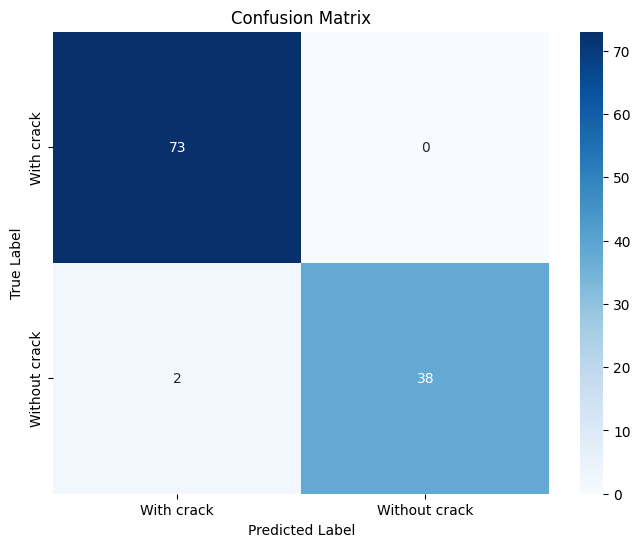

In [60]:
# Plot Confusion Matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [61]:
# 3. Class Accuracy (from CM)

class_accuracies = cm.diagonal() / cm.sum(axis=1)
print("\nClass-wise Accuracy:")
for i, label in enumerate(class_labels):
    print(f"{label}: {class_accuracies[i] * 100:.2f}%")



Class-wise Accuracy:
With crack: 100.00%
Without crack: 95.00%


In [62]:
# 4. Precision, Recall, F1-score

print("\nClassification Report:")
print(classification_report(Y_true_labels, Y_pred_labels, target_names=class_labels))



Classification Report:
               precision    recall  f1-score   support

   With crack       0.97      1.00      0.99        73
Without crack       1.00      0.95      0.97        40

     accuracy                           0.98       113
    macro avg       0.99      0.97      0.98       113
 weighted avg       0.98      0.98      0.98       113




--- AUC & ROC Curve ---

Overall AUC Score: 1.0000


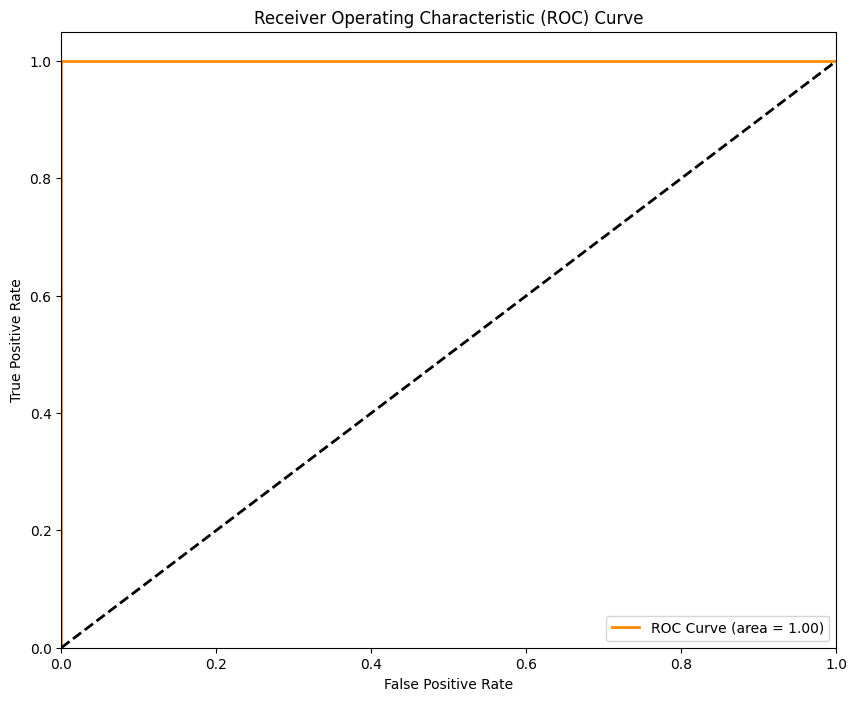


Total Training Time: 401.94s
Evaluation Time: 20.52s

Model saved as efficientnetb0_fine_tuned_model.h5


In [63]:
# 5. AUC & ROC Curve

print("\n--- AUC & ROC Curve ---")


positive_class_probs = Y_pred_probs[:, 1]


auc_score = roc_auc_score(Y_true_labels, positive_class_probs)
print(f"\nOverall AUC Score: {auc_score:.4f}")

fpr, tpr, _ = roc_curve(Y_true_labels, positive_class_probs)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
print(f"\nTotal Training Time: {total_training_time:.2f}s")
print(f"Evaluation Time: {testing_time:.2f}s")

# --- 6. Save Model ---
model.save('efficientnetb0_fine_tuned_model.h5')
print("\nModel saved as efficientnetb0_fine_tuned_model.h5")